In [35]:
import numpy as np
from numpy import sin,cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt

![four bar](http://daerospace.com/wp-content/uploads/sites/4/2015/12/FBLDescFig1-1024x566.png)

In [36]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians'''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],\
                [np.sin(theta),np.cos(theta)]])
    
    return A

def A_theta(theta):
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],[np.cos(theta),-np.sin(theta)]])
    return dAda

In [41]:
?rotA

Signature: rotA(theta)
Docstring:
This function returns a 2x2 rotation matrix to convert the 
rotated coordinate to the global coordinate system
input is angle in radians
File:      ~/Documents/UConn/ME5180/me5180_F2019/Computational_Dynamics/<ipython-input-36-f0394c24669e>
Type:      function


In [204]:
def C4B(q,t,l1,l2,l3,l4):
    '''q=[r2x,r2y,a2,
          r3x,r3y,a3,
          r4x,r4y,a4]'''
    q=np.reshape(q,(9,-1))
    #print(rotA(q[8][0])@np.array([[1],[0]]))
    C=np.zeros((9,1))
    #C[0:2]=q[0:2]+rotA(q[2][0])@np.array([[-l2/2],[0]])
    C[0:2]=C_pin(q[0:3],np.array([[-l2/2],[0]]),np.array([0,0,0]),np.array([[0],[0]]))
    C[2:4]=q[0:2]+rotA(q[2][0])@np.array([[l2/2],[0]])\
    -q[3:5]-rotA(q[5][0])@np.array([[-l3/2],[0]])
    C[4:6]=q[3:5]+rotA(q[5][0])@np.array([[l3/2],[0]])\
    -q[6:8]-rotA(q[8][0])@np.array([[l4/2],[0]])
    C[6:8]=q[6:8]+rotA(q[8][0])@np.array([[-l4/2],[0]])\
    -np.array([[l1],[0]])
    C[8]=q[2]-np.pi/2-np.arcsin(0.6)-1*t
    return C.reshape(9)

In [235]:
def C_pin(q1,u1,q2,u2):
    '''q1 is generalized coordinate of body 1 [R1x,R1y,theta1]
       q2 is generalized coordinate of body 2 [R2x,R2y,theta2]'''
    q1=q1.reshape(3,1)
    q2=q2.reshape(3,1)
    print(rotA(q1[2,0])@u1)
    print(q1[0:2,0])
    print(q1[0:2,0].T+rotA(q1[2,0])@u1)
    Cpin=q1[0:2,0]+rotA(q1[2,0])@u1-q2[0:2]-rotA(q2[2,0])@u2
    return Cpin

In [237]:
C_pin(q0[0:3],np.array([[-0.5],[0]]),np.array([[0],[0],[0]]),np.array([[0],[0]]))

[[ 0.3]
 [-0.4]]
(2,)
[[-29.7  40.3]
 [-30.4  39.6]]


IndexError: too many indices for array

In [224]:
f=np.zeros((1,5))
f[0,0:6]=np.array([1,2,3,4,5])
f

array([[1., 2., 3., 4., 5.]])

In [223]:
f.shape

(1, 5)

array([[-29.7],
       [ 39.6]])

In [211]:
def Cq_pin(u1,a1,u2,a2):
    '''dR/dR = identity
       dA/dtheta = Atheta'''
    u1=np.reshape(u1,(2,-1))
    u2=np.reshape(u2,(2,-1))
    Cq_1=np.append(np.identity(2),A_theta(a1)@u1[0:2],axis=1)
    Cq_2=np.append(-np.identity(2),-A_theta(a2)@u2[0:2],axis=1)
    Cq_pin=np.append(Cq_1,Cq_2,axis=1)
    return Cq_pin

def C4Bq(q,t,l1,l2,l3,l4):
    '''q=[r1x,r1y,a1,
      r2x,r2y,a2,
      r3x,r3y,a3]'''
    Cq=np.zeros((9,9))
    q=np.reshape(q,(9,-1))
    C20=-Cq_pin(np.array([[0],[0]]),0,np.array([[-l2/2], [0]]),q[2][0])
    Cq[0:2,0:3]=C20[:,3:6]
    Cq[2:4,0:6]=Cq_pin(np.array([[l2/2],[0]]),q[2][0],np.array([[-l3/2], [0]]),q[5][0])
    Cq[4:6,3:9]=Cq_pin(np.array([[l3/2],[0]]),q[5][0],np.array([[l4/2], [0]]),q[8][0])
    C4C=Cq_pin(np.array([[-l4/2],[0]]),q[8][0],np.array([[l1], [0]]),0)
    Cq[6:8,6:9]=C4C[:,0:3]
    Cq[8,2]=1
    return Cq

In [212]:
t=np.linspace(0,4*np.pi,1000)
l1=-75
l2=100
l3=100
l4=100
#l1=l2=l3=l4=100
q0=np.array([-30,40,np.pi/2+np.arcsin(0.6),60,130,np.arcsin(10/26),180,90,pi/2])
print(C4B(q0,0,l1,l2,l3,l4))
q=np.zeros((len(q0),len(t)))
for i,tt in enumerate(t):
    q[:,i]=fsolve(lambda q: C4B(q,tt,l1,l2,l3,l4),q0, \
                  fprime= lambda q: C4Bq(q,tt,l1,l2,l3,l4))
    
    q0=q[:,i]
#C4B(q,0,1,1,1,1)

[-7.10542736e-15 -7.10542736e-15 -7.38461538e+01 -3.07692308e+01
 -7.38461538e+01  9.23076923e+00  2.55000000e+02  4.00000000e+01
 -1.11022302e-16]


Text(0.5, 1.0, 'paths of link centers')

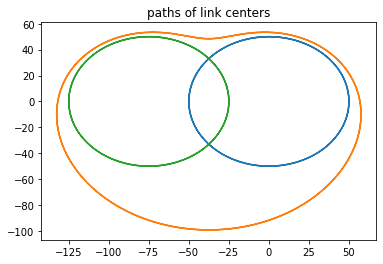

In [213]:
plt.plot(q[0,:],q[1,:])
plt.plot(q[3,:],q[4,:])
plt.plot(q[6,:],q[7,:])
plt.title('paths of link centers')

In [121]:
C4B(q[:,0],0,l1,l2,l3,l4)

array([-3.55271368e-15,  0.00000000e+00, -2.30450325e-10,  1.39422696e-10,
        2.47140974e-10,  1.93377758e-10,  4.77598405e-10,  5.39550626e-11,
       -1.11022302e-16])

In [122]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [127]:
def plot_shape(shape,dims,q):
    if shape=='link':
        Px=q[0]+np.array([dims[0]/2*np.cos(q[-1]),-dims[0]/2*np.cos(q[-1])])
        Py=q[1]+np.array([dims[0]/2*np.sin(q[-1]),-dims[0]/2*np.sin(q[-1])])
        l,= plt.plot(Px,Py,'o-')
        return l
    elif shape=='base':
        Px=q[0]
        Py=q[1]
        l,=plt.plot(Px,Py,'s',markersize=20)
        return l
    else:
        print('choose a \'link\' or \'base\' please')
        return 0

def plot_qs(q,shapes,dims,i):
    qi=q[:,i]
    f=plt.figure()
    if len(qi)/3 !=len(shapes):
        print('len(q) is %i. It needs %i more shapes '%(len(qi),len(qi)/3-len(shapes)))
    elif len(qi)/3==len(shapes):
        for i,s in enumerate(shapes):
            p=plot_shape(s,dims[i],qi[3*i:3*i+3])
            plt.plot(q[3*i,:],q[3*i+1,:]) # q[0], q[1] and q[3], q[4]  and q[6],q[7]
        a=f.gca()
        #l2,l3=links()
        plt.title('Angle 2 = %1.1f deg'%(qi[5]*180/pi))
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        #a.axis([2*np.min(q[:,0::3]),1.1*np.max(q[:,0::3]),\
        #        2*np.min(q[:,1::3]),1.1*np.max(q[:,1::3])])
        a.axis([-150,150,-100,100])
    #return p
    
    

In [128]:
j=interact(lambda i: plot_qs(q,['link','link','link'],[[l2],[l3],[l4]],i),i=(0,1000-1))

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

In [27]:
q[2::3,0]*180/np.pi

array([126.86989765,  22.61986495,  90.        ])

In [28]:
np.cos(q[2::3,0])

array([-6.00000000e-01,  9.23076923e-01,  6.12323400e-17])

In [29]:
np.sin(q[2::3,0])

array([0.8       , 0.38461538, 1.        ])